# Identifying Distinctive Terms in Presidential Papers Using TF*IDF
*Isaac Wink and Brice Bowrey*


In [ ]:
# Library imports
import requests
import json
import math
import pandas as pd
from sklearn import preprocessing
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Accessing Data

In [ ]:
# We built a custom workset containing one volume each from six separate presidents:
htid_title_dict = {"osu.32435051242188" : "Truman",
                   "osu.32437000791067" : "Hoover",
                   "uc1.31210014062952" : "Clinton",
                   "osu.32435030026934" : "Nixon",
                   "uc1.31210021820087" : "Obama",
                   "uc1.c109482027" : "Eisenhower"}

In [ ]:
def post_workset():
  ''' Post a workset to the HTRC Extracted Features API and return the workset ID '''
  url = "https://data.htrc.illinois.edu/ef-api/worksets"

  payload = "osu.32437000791067 osu.32435051242188 uc1.c109482027 osu.32435030026934 uc1.31210014062952 uc1.31210021820087"
  headers = {
      "Content-Type": "text/plain",
      "Accept": "application/json"
  }

  response = requests.post(url, data=payload, headers=headers)
  response_json = response.json()

  workset_id = response_json['data']['id']

  return workset_id

In [ ]:
workset_id = post_workset()

In [ ]:
workset_id

'664e9a5938000014012eeda9'

In [ ]:
def get_workset(workset_id, save_data=False):
  '''Uses the HTRC Extracted Features API to retrieve volume data for a workset ID.'''
  api_get_volume = "https://data.htrc.illinois.edu/ef-api/worksets/{}/volumes/aggregated".format(workset_id)
  response = requests.get(api_get_volume)

  # Check if the request was successful
  workset_data = response.json()

  if save_data:
    with open(file=volume_id, mode='w') as f:
      json.dump(workset_data, f)

  if workset_data["code"] == 200:
    print("Successfully retrieved data from API")
    return workset_data
  else:
    print(f'Failed to retrieve data: {workset_data["code"]}')
    return None

In [ ]:
def get_workset_volumes_aggregated(workset_data):
  '''Extracts the volume IDs and feature data from the workset data'''
  workset_total_wc = {} # {volume_id:{word:count}}
  for volume in workset_data['data']:
    volume_id = volume['htid']
    # workset_total_wc['{}'.format(volume_id)] = {}
    workset_total_wc['{}'.format(volume_id)] = volume['features']['body']

  return workset_total_wc

In [ ]:
workset_data = get_workset(workset_id)
workset_wc = get_workset_volumes_aggregated(workset_data)

Successfully retrieved data from API


In [ ]:
# Create a dataframe from the dictionary, making all words lowercase and removing non-alphanumeric words:
wc_dict = {}
for volume in workset_wc.keys():
  wc_dict[volume] = {}
  for term in workset_wc[volume].keys():
    lower_term = term.lower()
    if not lower_term.isalpha():
      continue
    if lower_term in wc_dict[volume].keys():
      wc_dict[volume][lower_term] += workset_wc[volume][term]
    else:
      wc_dict[volume][lower_term] = workset_wc[volume][term]

# Convert dict to list for adding to dataframe:
volume_id_list = []
term_list = []
count_list = []
for volume in wc_dict.keys():
  for term in wc_dict[volume].keys():
    volume_id_list.append(volume)
    term_list.append(term)
    count_list.append(wc_dict[volume][term])

# Create the dataframe containing term frequencies separated by volume:
corpus_df = pd.DataFrame({'term': term_list, 'volume_id': volume_id_list, 'count': count_list})

# TF*IDF Calculations, Table Creation, and Visualization

In [ ]:
# Function for tf*idf calulcation:
def tf_idf(term, volume, corpus):
  try:
    tf = corpus[(corpus["term"] == term) & (corpus["volume_id"] == volume)]["count"].values[0]
  except:
    return 0
  idf = math.log(len(workset_wc.keys()) / (corpus[(corpus["term"] == term)].shape[0] + 1))
  return tf*idf

In [ ]:
# Produce a df containing tf*idf scores for the first 10000 terms in a volume (limited for time's sake):
def volume_tf_idf(volume, corpus):
  tf_idf_scores_dict = {}
  volume_tf_df = corpus[(corpus["volume_id"] == volume)]
  count = 0
  for token in volume_tf_df["term"]:
    tf_idf_score = tf_idf(token, volume, corpus)
    tf_idf_scores_dict[token] = tf_idf_score
    count += 1
    # To change number of tf*idf scores calculate, change the number below:
    if count % 10000 == 0:
      print(f"Processed {count} terms")
      break
  tf_idf_scores_df = pd.DataFrame({"term" : tf_idf_scores_dict.keys(), "tf_idf_score" : tf_idf_scores_dict.values()})
  return tf_idf_scores_df.sort_values(by="tf_idf_score", ascending=False)

In [ ]:
# Generate tf*idf score dataframes for all volumes in the workset, and normalize tf*idf scores:
# Dataframes are saved to csv files
volume_list = workset_wc.keys()
for volume in volume_list:
  tf_idf_df = volume_tf_idf(volume, corpus_df)
  tf_idf_df['tfidf_normalized'] = preprocessing.normalize(tf_idf_df[['tf_idf_score']], axis=0, norm='l2')
  tf_idf_df.to_csv(f"{volume}.csv")

Processed 10000 terms
Processed 10000 terms
Processed 10000 terms
Processed 10000 terms
Processed 10000 terms


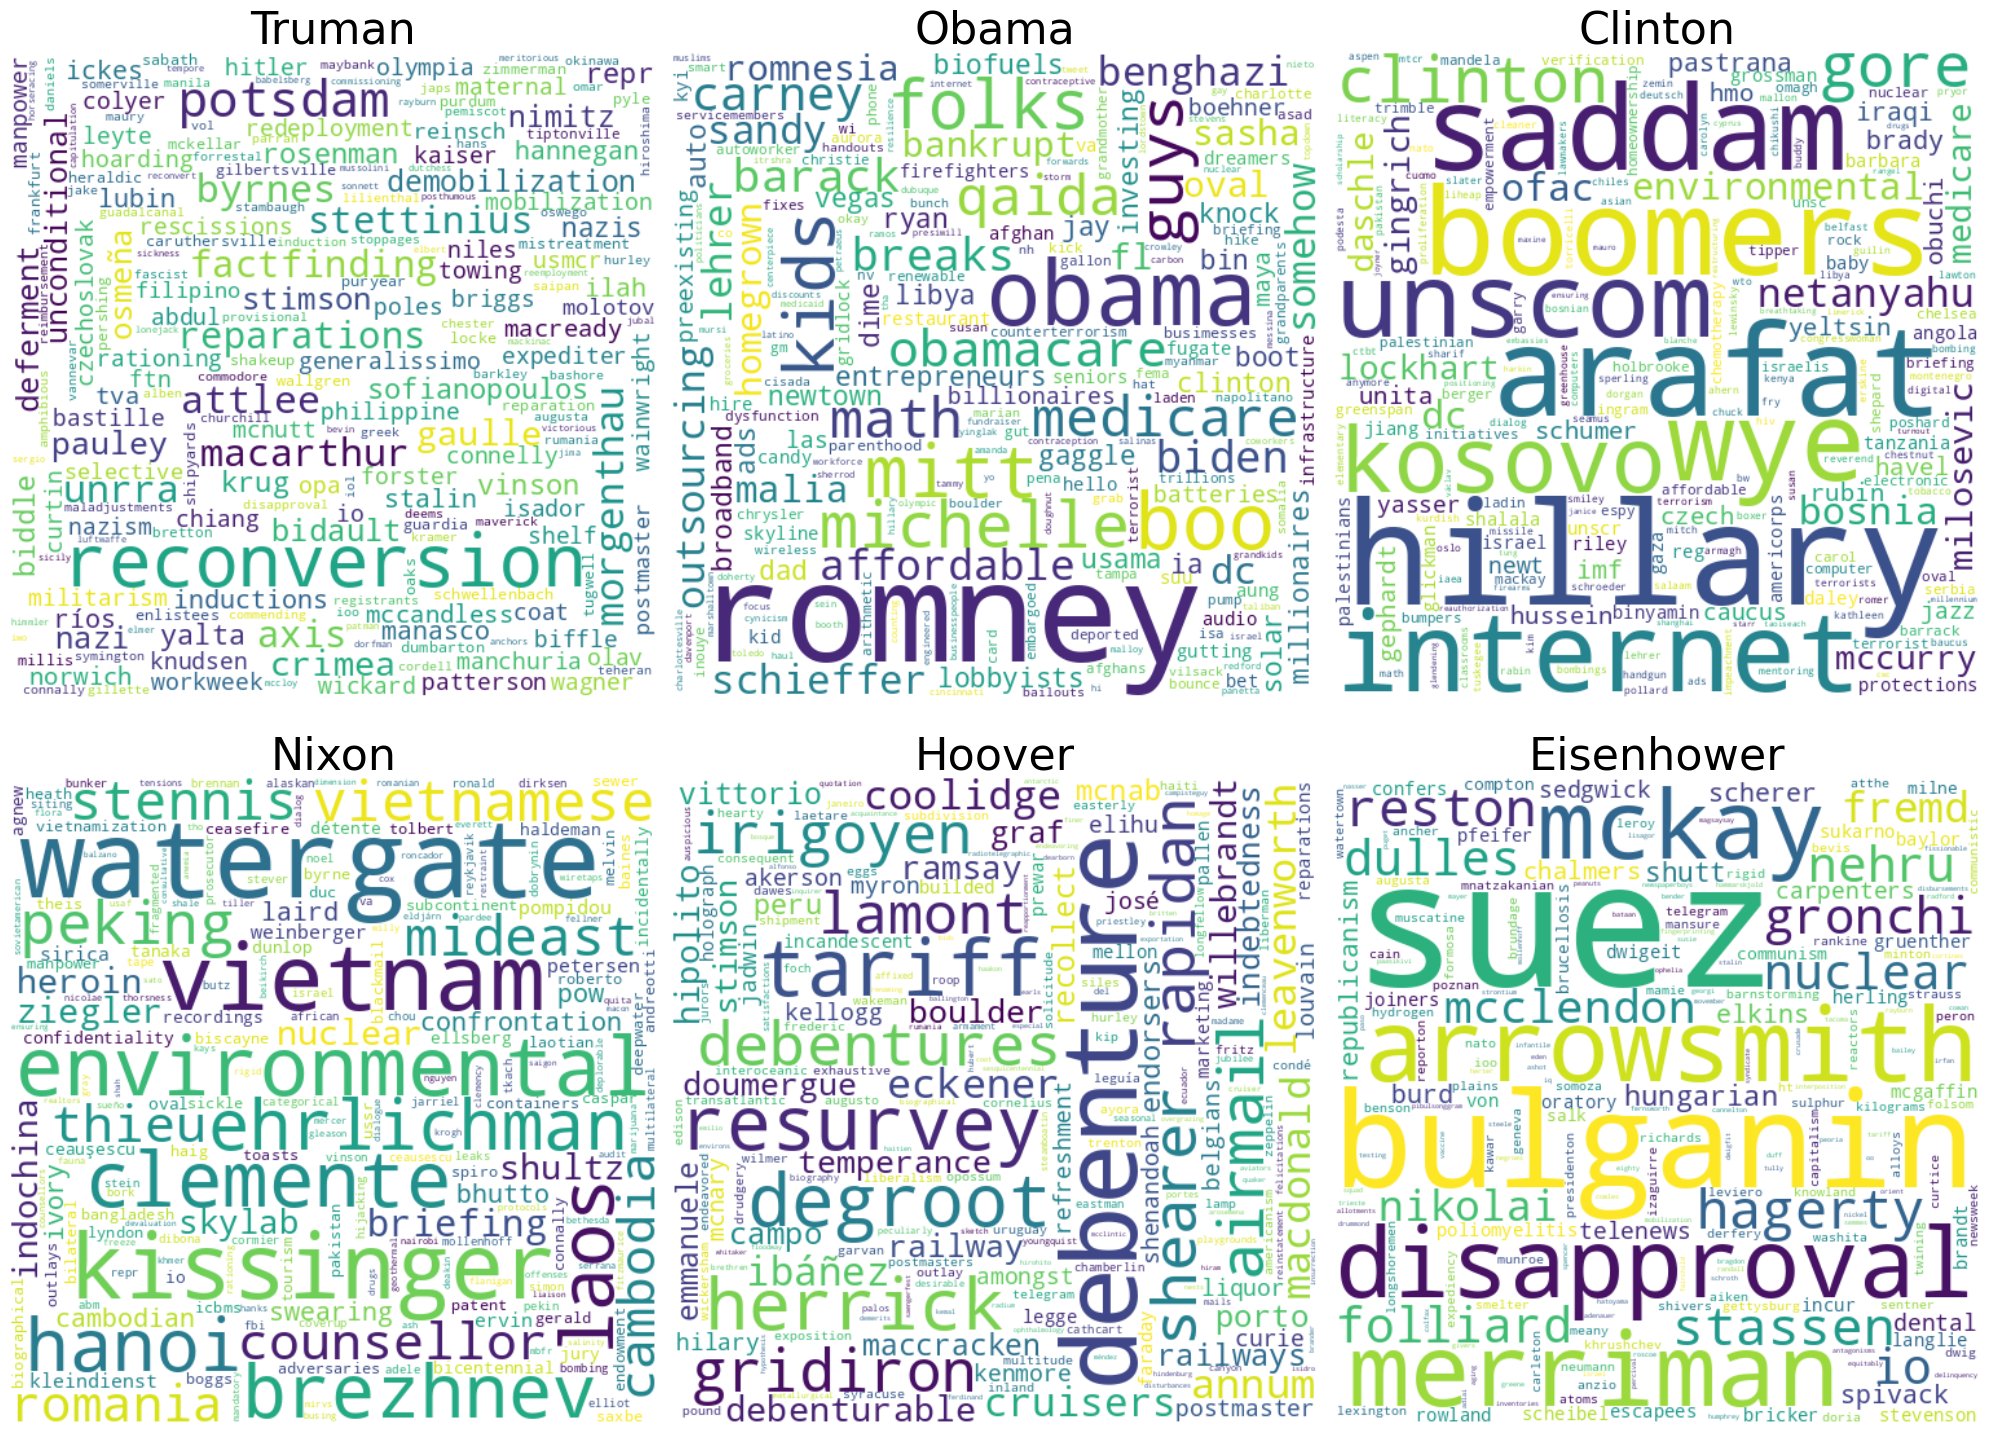

In [ ]:
# Generate wordclouds by volume of highest tf*idf scores
# The plotting code needs to be adjusted for worksets of different sizes
df_list = []
titles_list = []
filenames = os.listdir('.')
for file in filenames:
   if file[-4:] == ".csv":
     df = pd.read_csv(file)
     # Fill in NaN values
     df['tfidf_normalized'] = df['tfidf_normalized'].fillna(0.0)
     # Ensure all tf_idf values are float
     df['tfidf_normalized'] = df['tfidf_normalized'].astype(float)
     # Ensure all term values are strings:
     df['term'] = df['term'].astype(str)
     df_list.append(df)
     titles_list.append(htid_title_dict[file[:-4]])
     if len(df_list) == 9:
      break
fig, axes = plt.subplots(2, 3, figsize=(20, 15))

for ax, i in zip(axes.flatten(), range(len(df_list))):
    terms = dict(zip(df_list[i]['term'], df_list[i]['tfidf_normalized']))
    wordcloud = WordCloud(width=500, height=500, background_color='white').generate_from_frequencies(terms)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(titles_list[i], fontsize=32)
    ax.axis('off')

plt.tight_layout()
plt.show()

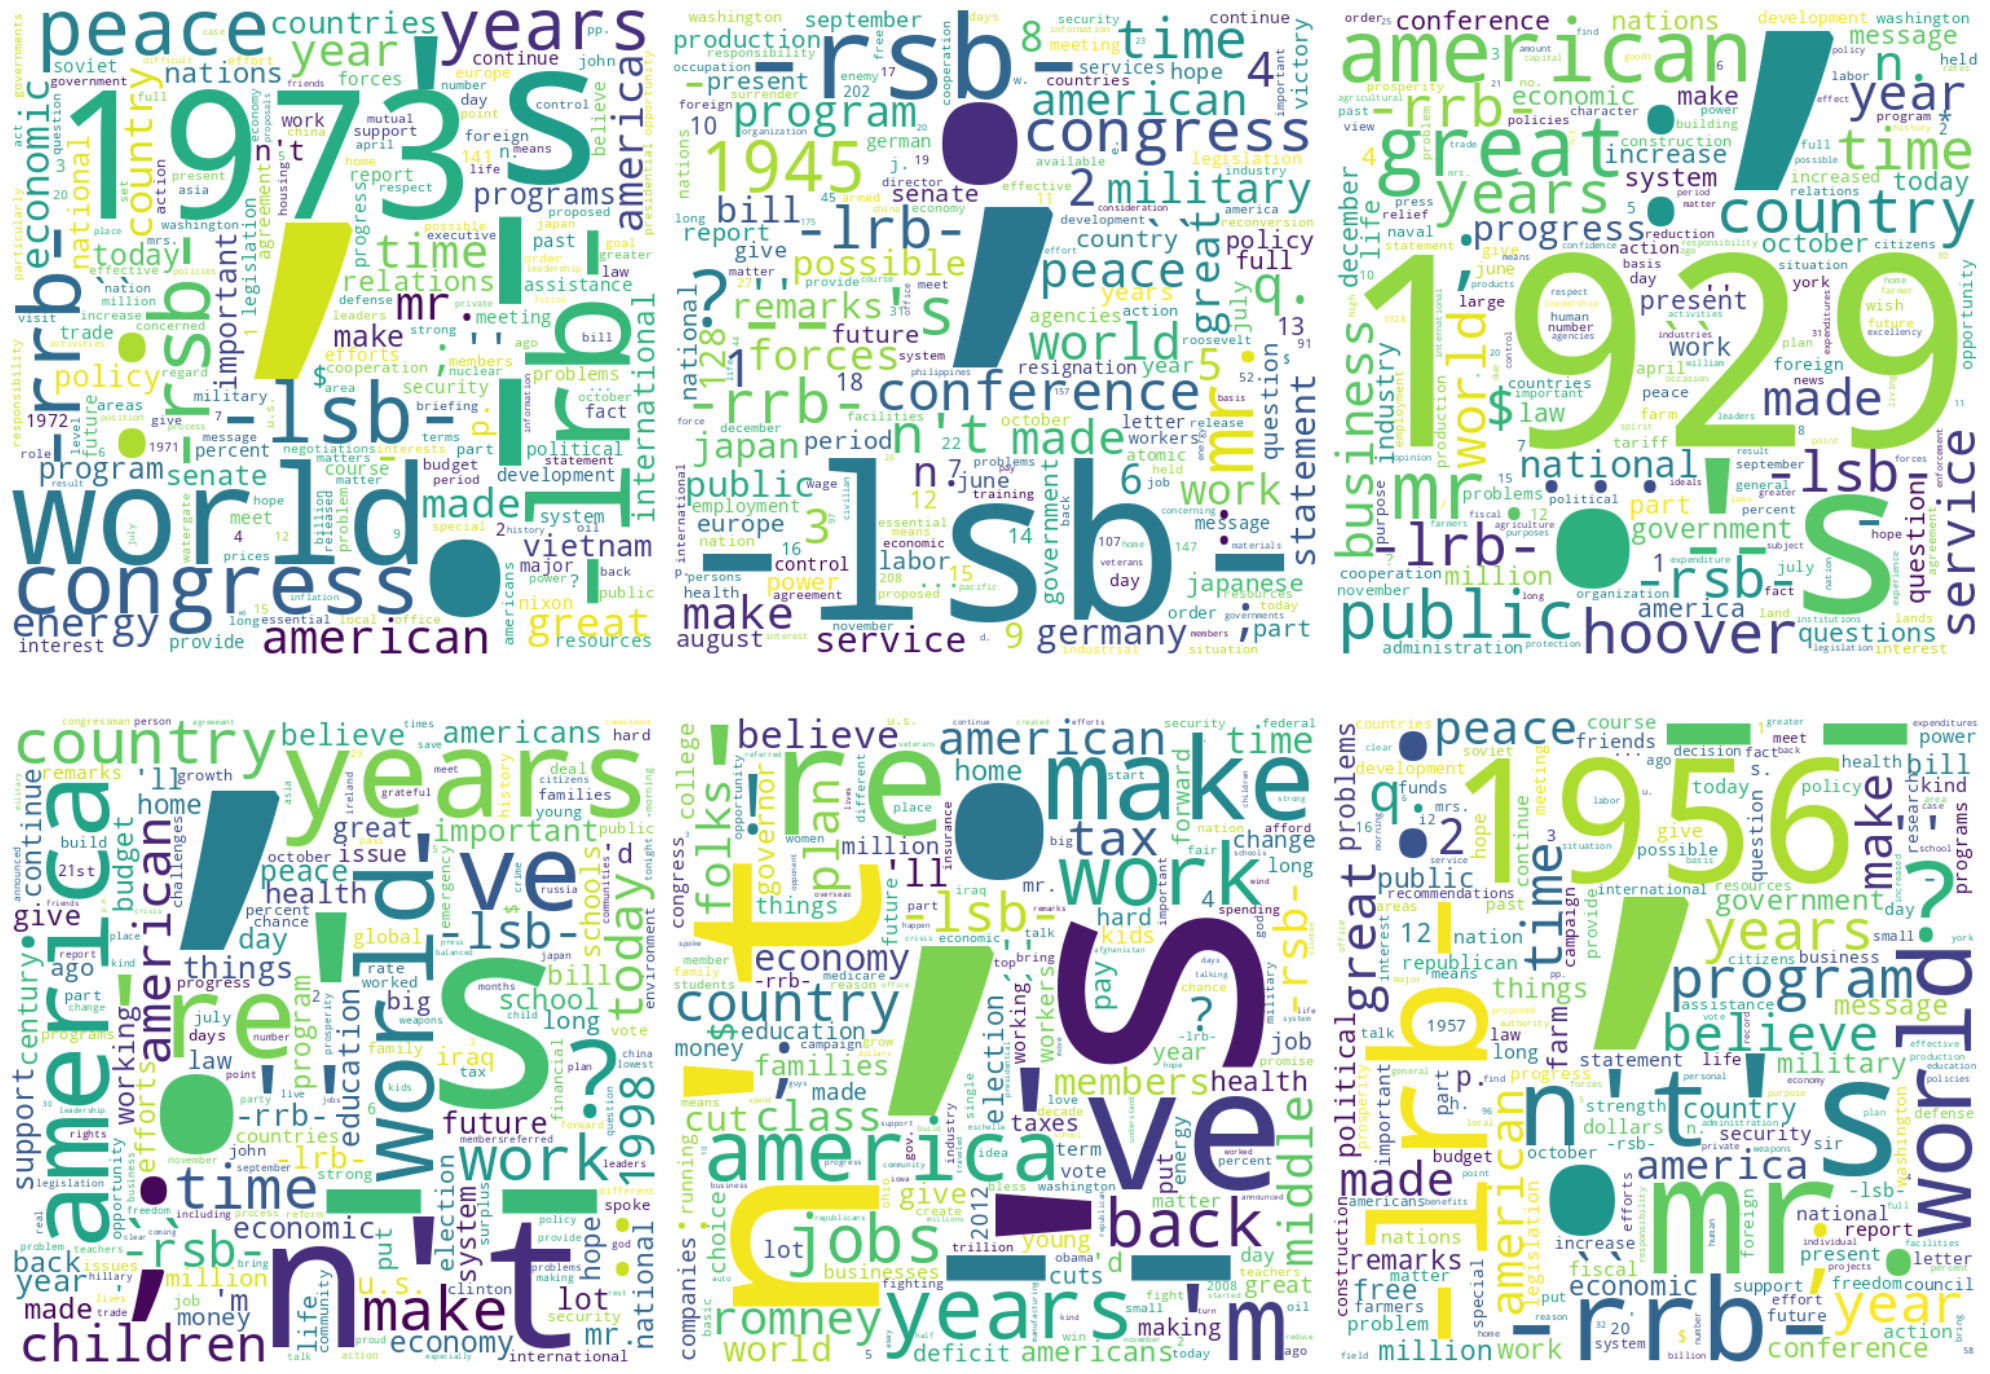

In [ ]:
# For comparison, generate wordclouds of the most frequently occurring words by volume (removing some stopwords):
fig, axes = plt.subplots(2, 3, figsize=(20, 15))

for ax, id in zip(axes.flatten(), workset_wc.keys()):
    df = pd.DataFrame({"term" : workset_wc[id].keys(), "count" : workset_wc[id].values()})
    df["term"] = df["term"].apply(str.lower)
    df = df[(df["term"].isin(stopwords.words()) == False)]
    terms = dict(zip(df["term"], df["count"]))
    wordcloud = WordCloud(width=500, height=500, background_color='white').generate_from_frequencies(terms)
    ax.imshow(wordcloud, interpolation='bilinear')
    #ax.set_title(titles_list[i], fontsize=32)
    ax.axis('off')

plt.tight_layout()
plt.show()